In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()



# Loading and Previewing the Data

In [ ]:
df = pd.read_csv('/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [ ]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 31478 (\N{CJK UNIFIED IDEOGRAPH-7AF6}) missing from current font.
  func(*args, *

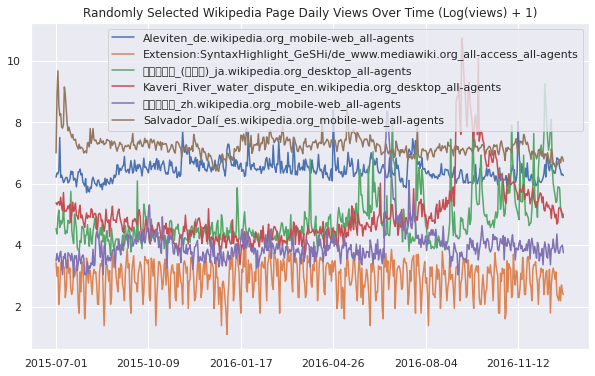

In [ ]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

# Formatting the Data for Modeling

We'll use a style of walk-forward validation, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 60 days). This way, we simulate how our model will perform on unseen data that comes in the future.

### Train and Validation Series Partioning
We need to create 4 sub-segments of the data:

1. Train encoding period
2. Train decoding period (train targets, 60 days)
3. Validation encoding period
4. Validation decoding period (validation targets, 60 days)

We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals.

In [ ]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [ ]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [ ]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-09-02 00:00:00
Train prediction: 2016-09-03 00:00:00 - 2016-11-01 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2016-11-01 00:00:00
Val prediction: 2016-11-02 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 430
Prediction interval: 60


# Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. 

In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

# Building the Model - Architecture

This convolutional architecture is a full-fledged version of the WaveNet model, designed as a generative model for audio (in particular, for text-to-speech applications). The wavenet model can be abstracted beyond audio to apply to any time series forecasting problem, providing a nice structure for capturing long-term dependencies without an excessive number of learned weights.

The core building block of the wavenet model is the dilated causal convolution layer, discussed in detail in the previous notebook of this series as well as the accompanying blog post. In summary, this style of convolution properly handles temporal flow and allows the receptive field of outputs to increase exponentially as a function of the number of layers. This structure is nicely visualized by the below diagram from the wavenet paper.

# Our Architecture
With all of our components now laid out, here's what we'll use:

16 dilated causal convolutional blocks
Preprocessing and postprocessing (time distributed) fully connected layers (convolutions with filter width 1): 16 output units
32 filters of width 2 per block
Exponentially increasing dilation rate with a reset (1, 2, 4, 8, ..., 128, 1, 2, ..., 128)
Gated activations
Residual and skip connections
2 (time distributed) fully connected layers to map sum of skip outputs to final output
We'll extract the last 60 steps from the output sequence as our predicted output for training. We'll use teacher forcing again during training. Similarly to the previous notebook, we'll have a separate function that runs an inference loop to generate predictions on unseen data, iteratively filling previous predictions into the history sequence.

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

2023-01-17 10:53:30.042311: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
first_n_samples = 120000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)  

2023-01-17 10:53:34.686319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
47/47 [==============================] - 625s 13s/step - loss: 0.3899 - val_loss: 0.2865
Epoch 2/10
47/47 [==============================] - 608s 13s/step - loss: 0.2999 - val_loss: 0.2652
Epoch 3/10
47/47 [==============================] - 607s 13s/step - loss: 0.2851 - val_loss: 0.2575
Epoch 4/10
47/47 [==============================] - 608s 13s/step - loss: 0.2785 - val_loss: 0.2531
Epoch 5/10
47/47 [==============================] - 607s 13s/step - loss: 0.2743 - val_loss: 0.2511
Epoch 6/10
47/47 [==============================] - 611s 13s/step - loss: 0.2713 - val_loss: 0.2486
Epoch 7/10
47/47 [==============================] - 610s 13s/step - loss: 0.2691 - val_loss: 0.2469
Epoch 8/10
47/47 [==============================] - 618s 13s/step - loss: 0.2676 - val_loss: 0.2448
Epoch 9/10
47/47 [==============================] - 619s 13s/step - loss: 0.2662 - val_loss: 0.2433
Epoch 10/10
47/47 [==============================] - 615s 13s/step - loss: 0.2650 - val_loss: 0.2422

It's typically a good idea to look at the convergence curve of train/validation loss.

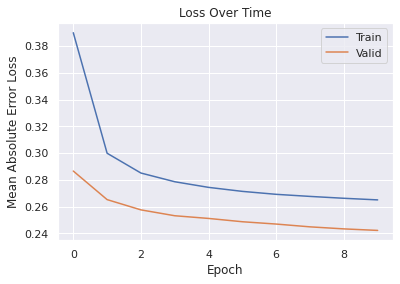

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Building the Model - Inference Loop
Like in the previous notebook, we'll generate predictions by running our model from section 3 in a loop, using each iteration to extract the prediction for the time step one beyond our current history then append it to our history sequence. With 60 iterations, this lets us generate predictions for the full interval we've chosen.

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

# Generating and Plotting Predictions
Now we have everything we need to generate predictions for encoder (history) /target series pairs that we didn't train on (note again we're using "encoder"/"decoder" terminology to stay consistent with notebook 1 -- here it's more like history/target). We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.

In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our longer time horizon predictions (60 days) are often strong and expressive. Our full-fledged model is able to effectively capture weekly seasonality patterns and long term trends, and does a very nice job adapting to the varying levels of fluctuation in each series.

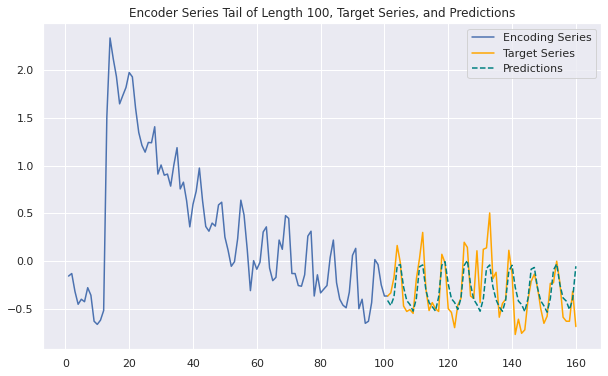

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16534, enc_tail_len=100)

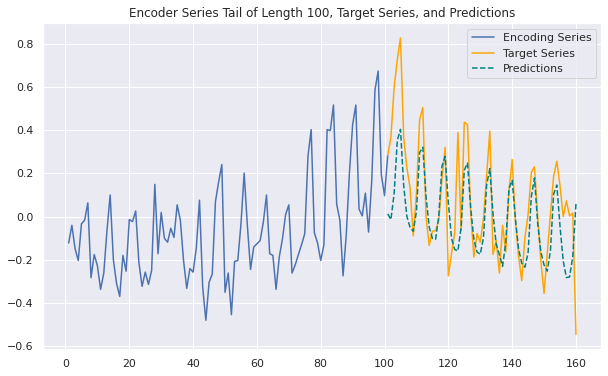

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16555, enc_tail_len=100)

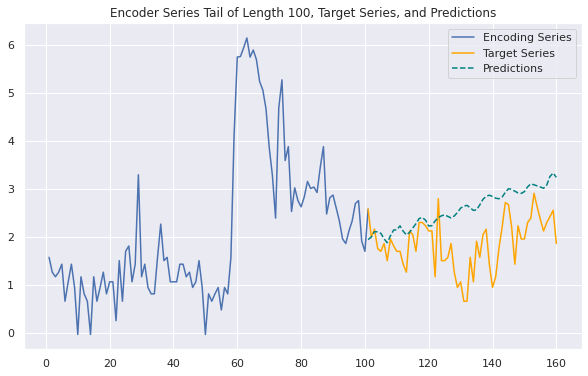

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=4000, enc_tail_len=100)

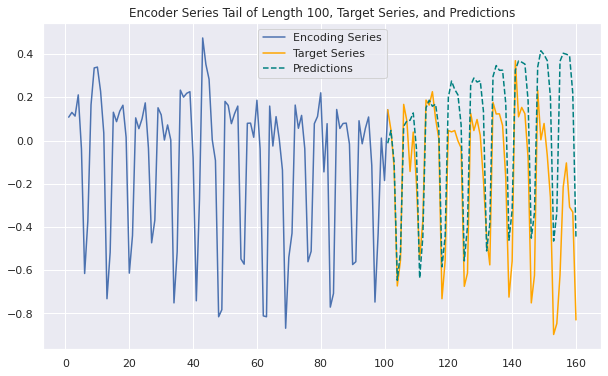

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=68000, enc_tail_len=100)

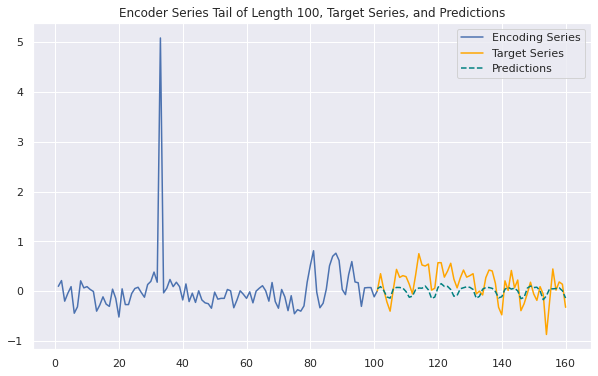

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=6007, enc_tail_len=100)

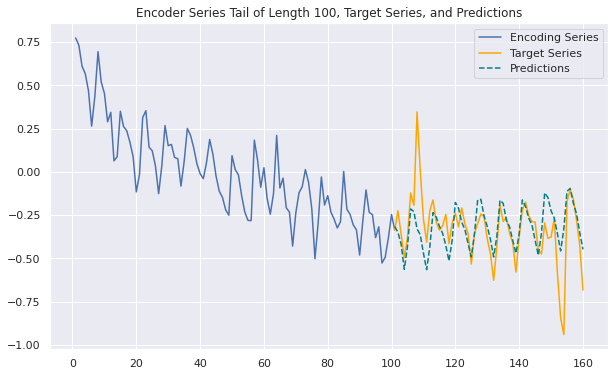

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=70450, enc_tail_len=100)

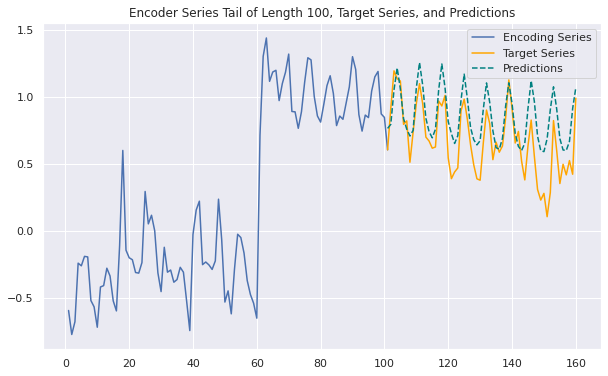

In [ ]:

predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16551, enc_tail_len=100)